In [1]:
import scanpy.api as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mode
from collections import Counter
import seaborn as sns
sc.settings.verbosity = 3 # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=170, color_map='viridis')  # low dpi (dots per inch) yields small inline figures
sc.logging.print_versions()
results_file = './intestine_cells.h5ad'
results_file_denoised = './intestine_cells_demo.h5ad'

scanpy==1.4.1 anndata==0.6.21 numpy==1.16.4 scipy==1.2.1 pandas==0.24.2 scikit-learn==0.21.2 statsmodels==0.10.0rc2 python-igraph==0.7.1 louvain==0.6.1 


Because we opened jupyter lab/notebook from the directory that we made, we only need to enter the path and filename starting from this point. We are going to use Scanpy's "read_10x_mtx" function because we are reading in a 10X mtx file to analyze. We could also start with a matrix generated from FeatureCounts or DESeq2 or any other program. To do this we could use the python package pandas like this:

## Starting from 10X Dataset

In [17]:
adata = sc.read_10x_mtx('/oasis/tscc/scratch/CSHL_single_cell_2019/scanpy/data/GSM2836573_Regional_Duo_M1/',
                       var_names='gene_symbols',                  # use gene symbols for the variable names (variables-axis index)
                        cache=True)

... reading from cache file cache/oasis-tscc-scratch-CSHL_single_cell_2019-scanpy-data-GSM2836573_Regional_Duo_M1-matrix.h5ad


In [68]:
#adata.var_names_make_unique()  # this is unnecessary if using 'gene_ids'

In [18]:
adata

AnnData object with n_obs × n_vars = 2348 × 27998 
    var: 'gene_ids'

In [19]:
adata.var_names

Index(['mm10_Xkr4', 'mm10_Gm1992', 'mm10_Gm37381', 'mm10_Rp1', 'mm10_Rp1-1',
       'mm10_Sox17', 'mm10_Gm37323', 'mm10_Mrpl15', 'mm10_Lypla1',
       'mm10_Gm37988',
       ...
       'mm10_AC125149.1', 'mm10_AC125149.2', 'mm10_AC125149.4',
       'mm10_AC234645.1', 'mm10_AC168977.2', 'mm10_AC168977.1', 'mm10_PISD',
       'mm10_DHRSX', 'mm10_Vmn2r122', 'mm10_CAAA01147332.1'],
      dtype='object', length=27998)

## Preprocessing

The preprocessing can be done somewhere else (such as in R) and then loaded into scanpy. If this is your situation, skip this portion. You can also freeze the raw data at any point if you want to come back to it. Set the .raw attribute of AnnData object to the logarithmized raw gene expression for later use in differential testing and visualizations of gene expression. This simply freezes the state of the AnnData object returned by sc.pp.log1p.

Take a quick look at the genes with the highest fraction of counts in each cell, across all cells

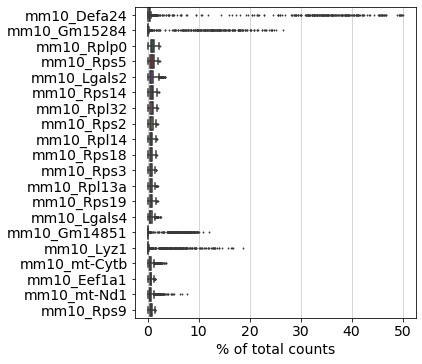

In [20]:
sc.pl.highest_expr_genes(adata, n_top=20)

Do some basic filtering:

In [21]:
sc.pp.filter_cells(adata, min_genes=800)

filtered out 91 cells that have less than 800 genes expressed


In [22]:
sc.pp.filter_genes(adata, min_cells=3)

filtered out 14756 genes that are detected in less than 3 cells


In [23]:
sc.pp.filter_genes(adata, min_counts=15)

filtered out 1962 genes that are detected in less than 15 counts


In [24]:
adata.n_vars

11280

In [25]:
adata.n_obs

2257

In [26]:
#sc.pp.calculate_qc_metrics(adata) - this command doesn't seem to be working with my version of numba

Let us assemple some information about mitochondrial genes, which are important for quality control.

Citing from “Simple Single Cell” workflows (Lun, McCarthy & Marioni, 2017):

High proportions are indicative of poor-quality cells (Islam et al. 2014; Ilicic et al. 2016), possibly because of loss of cytoplasmic RNA from perforated cells. The reasoning is that mitochondria are larger than individual transcript molecules and less likely to escape through tears in the cell membrane.

In [27]:
mito_genes = adata.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_mito'] = np.sum(adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

In [28]:
adata.obs.head()

,n_genes,percent_mito,n_counts
0,,,
AAACATACAGCGGA-1,1227,0.0,12763.0
AAACATACCTTACT-1,2156,0.0,6581.0
AAACATACTTTGCT-1,1424,0.0,2843.0
AAACCGTGCAGTCA-1,1362,0.0,2798.0
AAACGCTGCAGTCA-1,2287,0.0,6045.0


A violin plot of the computed quality measures.

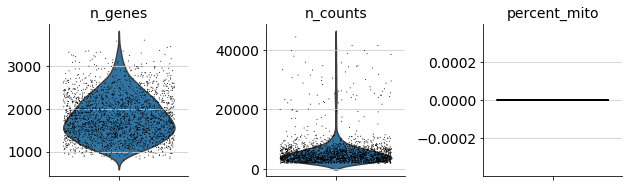

In [29]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],jitter=0.4, multi_panel=True)

Remove cells that have too many mitochondrial genes expressed or too many total counts.

/opt/conda/lib/python3.6/site-packages/scanpy/plotting/_anndata.py:311: DeprecationWarning: Use obs_vector instead of _get_obs_array, _get_obs_array will be removed in the future.
  x_arr = adata._get_obs_array(x, use_raw=use_raw, layer=layers[0])
/opt/conda/lib/python3.6/site-packages/anndata/base.py:1618: FutureWarning: In a future version of AnnData, access to `.X` by passing `layer='X'` will be removed. Instead pass `layer=None`.
  FutureWarning
/opt/conda/lib/python3.6/site-packages/scanpy/plotting/_anndata.py:312: DeprecationWarning: Use obs_vector instead of _get_obs_array, _get_obs_array will be removed in the future.
  y_arr = adata._get_obs_array(y, use_raw=use_raw, layer=layers[1])
/opt/conda/lib/python3.6/site-packages/anndata/base.py:1618: FutureWarning: In a future version of AnnData, access to `.X` by passing `layer='X'` will be removed. Instead pass `layer=None`.
  FutureWarning


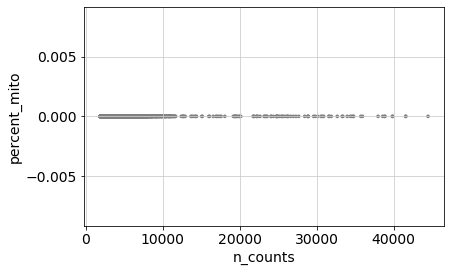

/opt/conda/lib/python3.6/site-packages/scanpy/plotting/_anndata.py:311: DeprecationWarning: Use obs_vector instead of _get_obs_array, _get_obs_array will be removed in the future.
  x_arr = adata._get_obs_array(x, use_raw=use_raw, layer=layers[0])
/opt/conda/lib/python3.6/site-packages/anndata/base.py:1618: FutureWarning: In a future version of AnnData, access to `.X` by passing `layer='X'` will be removed. Instead pass `layer=None`.
  FutureWarning
/opt/conda/lib/python3.6/site-packages/scanpy/plotting/_anndata.py:312: DeprecationWarning: Use obs_vector instead of _get_obs_array, _get_obs_array will be removed in the future.
  y_arr = adata._get_obs_array(y, use_raw=use_raw, layer=layers[1])
/opt/conda/lib/python3.6/site-packages/anndata/base.py:1618: FutureWarning: In a future version of AnnData, access to `.X` by passing `layer='X'` will be removed. Instead pass `layer=None`.
  FutureWarning


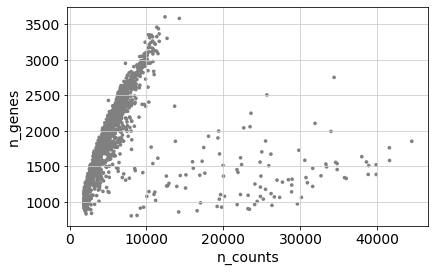

In [30]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='n_genes')

Actually do the filtering.

In [31]:
adata = adata[adata.obs['n_genes'] < 2500, :]
adata = adata[adata.obs['percent_mito'] < 0.05, :]

Total-count normalize (library-size correct) the data matrix to 10,000 reads per cell, so that counts become comparable among cells. Then log normalize the counts.

In [33]:
adata.n_obs

2030

In [34]:
adata.n_vars

11280

In [35]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)

Trying to set attribute `.obs` of view, making a copy.


Now we filter the data for the most variable genes

In [36]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


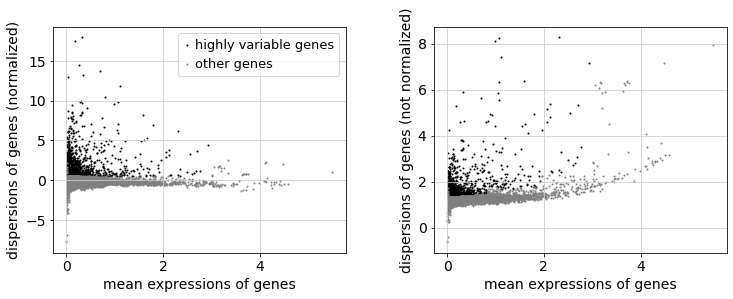

In [37]:
sc.pl.highly_variable_genes(adata)

Now do the filtering

In [38]:
adata = adata[:, adata.var['highly_variable']]

In [39]:
adata

View of AnnData object with n_obs × n_vars = 2030 × 1546 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'n_cells', 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'

We used to have 11k genes and now we are at 1546

Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed. Scale the data to unit variance.

In [40]:
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])

regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use
    finished (0:00:05.77)


Scale each gene to unit variance. Clip values exceeding standard deviation 10.

In [41]:
sc.pp.scale(adata, max_value=10)

## PCA

Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises (noise reduction) the data.

In [42]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA on highly variable genes


We can make a scatter plot in the PCA coordinates, but we will not use that later on.

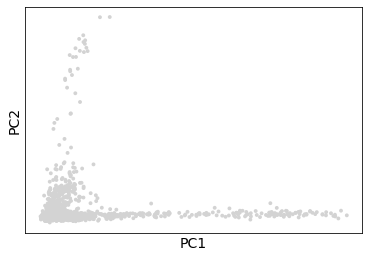

In [43]:
sc.pl.pca(adata)

If we want we can add additional genes to look at

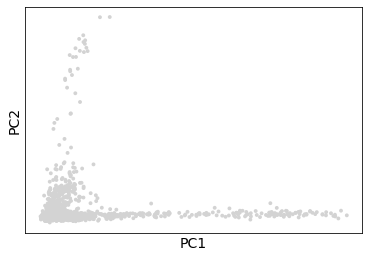

In [44]:
sc.pl.pca(adata)

Let us inspect the contribution of single PCs to the total variance in the data. This gives us information about how many PCs we should consider in order to compute the neighborhood relations of cells, e.g. used in the clustering function sc.tl.louvain() or tSNE sc.tl.tsne(). Usually, a rough estimate of the number of PCs does fine.

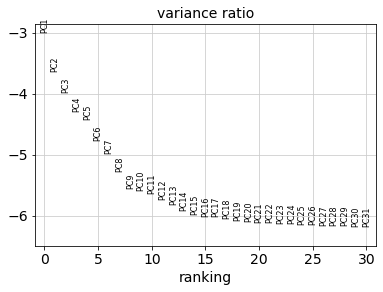

In [45]:
sc.pl.pca_variance_ratio(adata, log=True)

What we are looking for is how many principle components to use in the future computation of our neighborhood graphs. We can see from the graph above that we capture almost all of the varaiance in the first 7 principle components so that is the number we will use going forward.

Now lets save the results

In [46]:
adata.write(results_file)

In [47]:
adata

AnnData object with n_obs × n_vars = 2030 × 1546 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'n_cells', 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

## Computing the neighborhood graph

Using the PCA representation of the data matrix we can now compute the neighborhood graph. This means that we are estimating how connected all of the data points are - the connectivity of the manifold.

Scanpy pp.neighbors relies heavily on UMAP and the n_neighbors integer is the size of local neighborhood (in terms of number of neighboring data points) used for manifold approximation. Larger values result in more global views of the manifold, while smaller values result in more local data being preserved.

In [48]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=10)

computing neighbors
    using 'X_pca' with n_pcs = 10
    finished (0:00:05.35) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix


## Embedding the neighborhood graph

An embedding is a representation of a topological object, manifold, graph, field, etc. in a certain space in such a way that its connectivity or algebraic properties are preserved. Scanpy offers several flavors with different advantages and disadvantages to each: PCA, tSNE, UMAP, Force-directed, and Diffusion Maps. 

First we will try to UMAP (McInnes et al., 2018) https://arxiv.org/abs/1802.03426

In [49]:
sc.tl.umap(adata)

computing UMAP
    finished (0:00:06.09) --> added
    'X_umap', UMAP coordinates (adata.obsm)


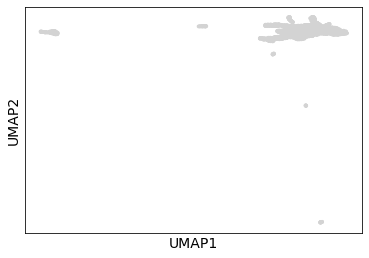

In [50]:
sc.pl.umap(adata)

If we knew something about these cells before sequencing we could add annotation and color the cells by that annotation. We can change some of the plotting parameters like this:

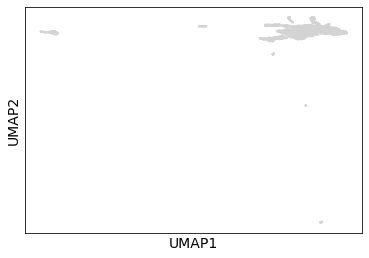

In [51]:
sc.pl.umap(adata, legend_fontsize=7, alpha=0.8, size=20)

If you also wanted to try the Force-directed graph drawing [Islam11] [Jacomy14] [Chippada18]. An alternative to tSNE that often preserves the topology of the data better. This requires to run neighbors(), first.

In [52]:
sc.tl.draw_graph(adata, layout='fr')

drawing single-cell graph using layout "fr"
    finished (0:00:40.60) --> added
    'X_draw_graph_fr', graph_drawing coordinates (adata.obsm)


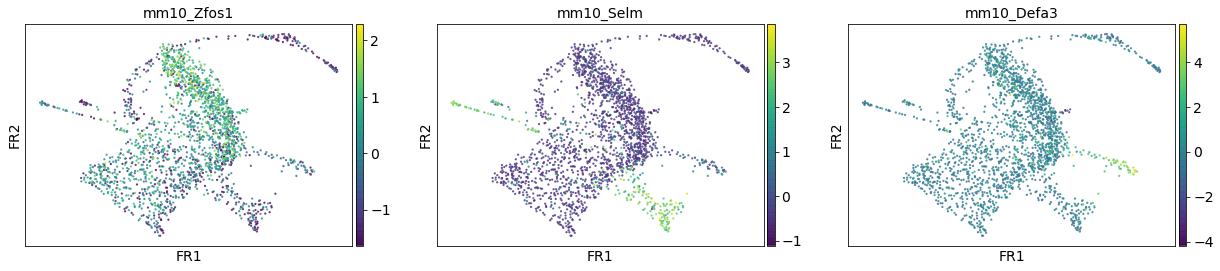

In [130]:
sc.pl.draw_graph(adata, color=['mm10_Zfos1','mm10_Selm','mm10_Defa3'], legend_fontsize=7, alpha=0.8, size=20)

Alternatively, if you want to produce a tSNE you can do the following:

In [70]:
sc.tl.tsne(adata, n_pcs = 10, early_exaggeration = 5)

computing tSNE
    using 'X_pca' with n_pcs = 10
    using sklearn.manifold.TSNE with a fix by D. DeTomaso
    finished (0:00:13.57) --> added
    'X_tsne', tSNE coordinates (adata.obsm)


There are several settings when computing tSNE but two are perplexity: "The perplexity is related to the number of nearest neighbors that is used in other manifold learning algorithms. Larger datasets usually require a larger perplexity. Consider selecting a value between 5 and 50. The choice is not extremely critical since t-SNE is quite insensitive to this parameter." 
and early_exaggeration: "Controls how tight natural clusters in the original space are in the embedded space and how much space will be between them. For larger values, the space between natural clusters will be larger in the embedded space. Again, the choice of this parameter is not very critical. If the cost function increases during initial optimization, the early exaggeration factor or the learning rate might be too high."

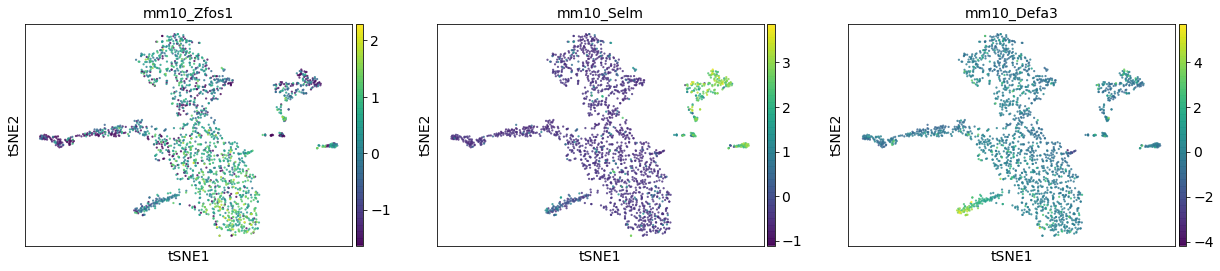

In [131]:
sc.pl.tsne(adata, color=['mm10_Zfos1','mm10_Selm','mm10_Defa3'], legend_loc='on data', legend_fontsize=7, alpha=0.8, size=20)




## Clustering the neighborhood graph

Seurat and many others recommend the Louvain graph-clustering method (community detection based on optimizing modularity). It has been proposed for single-cell data by Levine et al. (2015). Note that Louvain clustering directly clusters the neighborhood graph of cells, which we already computed in the previous section.

In [94]:
sc.tl.louvain(adata)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.29) --> found 14 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)


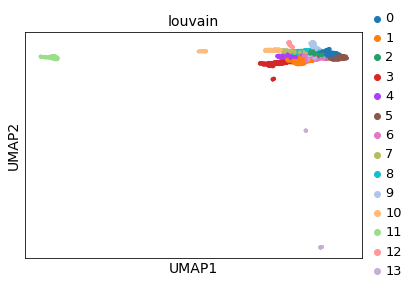

In [95]:
sc.pl.umap(adata, color='louvain')

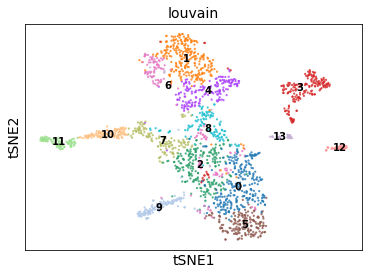

In [96]:
sc.pl.tsne(adata, color='louvain', legend_loc='on data', legend_fontsize=10, alpha=0.8, size=20)

When looking at both the UMAP and tSNE it looks to me like 10 clusters is a little ambitious. So if we want to recluster with a lower resolution we will get less clusters (1 is the default)

In [97]:
sc.tl.louvain(adata, resolution = 0.25)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.28) --> found 7 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)


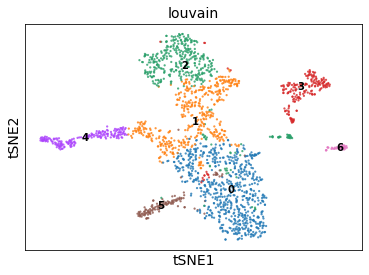

In [98]:
sc.pl.tsne(adata, color='louvain', legend_loc='on data', legend_fontsize=10, alpha=0.8, size=20)

Save the clustering graph to a pdf and then save the file.

saving figure to file ./figures/tsnetsne_lovain_res0_25.pdf


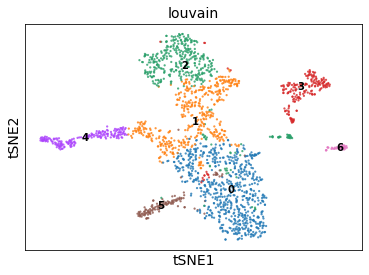

In [99]:
sc.pl.tsne(adata, color=['louvain'], legend_loc='on data', legend_fontsize=10, alpha=0.8, size=20, save = 'tsne_lovain_res0_25.pdf')

In [100]:
adata.write(results_file)

## Finding Marker Genes

The easiest way to do this is using a t-test to find differentially expressed genes between one cluster and all of the other clusters.

ranking genes
    finished (0:00:00.21) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids


/opt/conda/lib/python3.6/site-packages/scanpy/tools/_rank_genes_groups.py:224: RuntimeWarning: invalid value encountered in log2
  rankings_gene_logfoldchanges.append(np.log2(foldchanges[global_indices]))


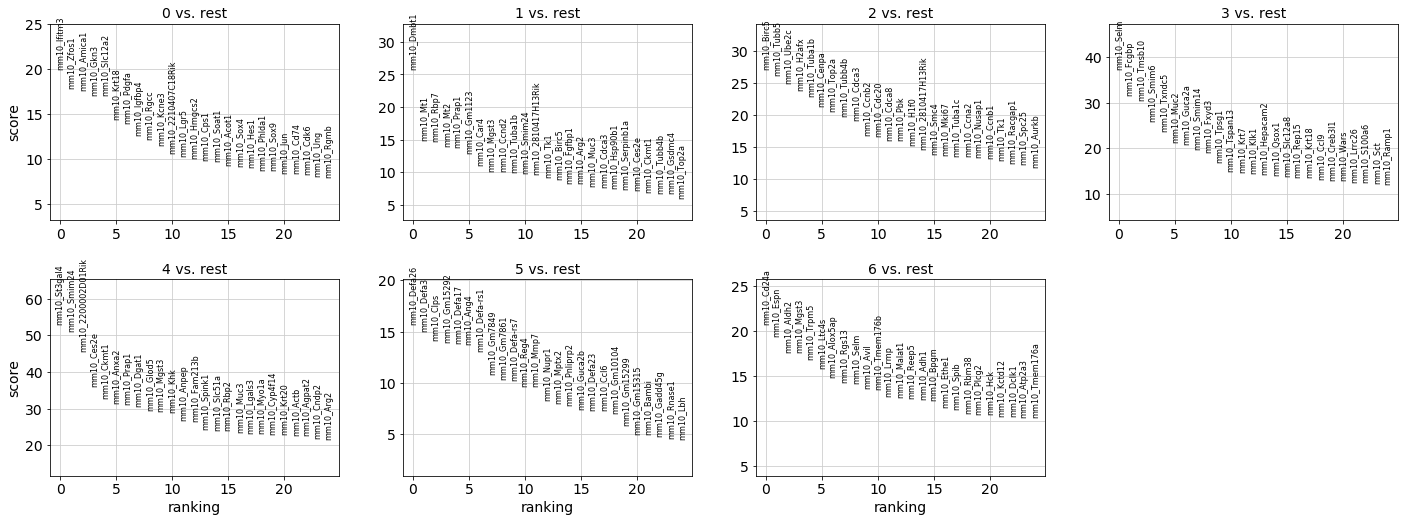

In [101]:
sc.tl.rank_genes_groups(adata, 'louvain', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

Check out a detailed explanation of the wilcoxin rank sum test [here](https://www.stat.auckland.ac.nz/~wild/ChanceEnc/Ch10.wilcoxon.pdf). 

The t-test assumes your data is normally distributed. This is often not the case. For a non-parametric test we can then use the Mann-Whitney test.

ranking genes


/opt/conda/lib/python3.6/site-packages/scanpy/tools/_rank_genes_groups.py:389: RuntimeWarning: invalid value encountered in log2
  rankings_gene_logfoldchanges.append(np.log2(foldchanges[global_indices]))


    finished (0:00:00.51) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids


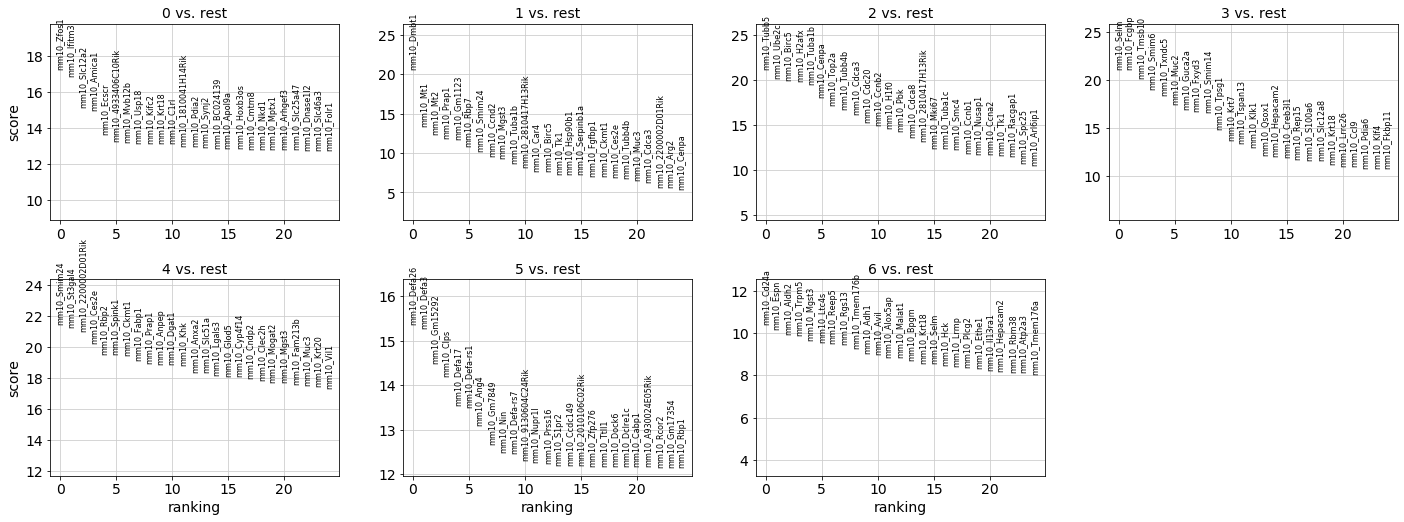

In [102]:
sc.tl.rank_genes_groups(adata, 'louvain', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

As an alternative, let us rank genes using logistic regression. For instance, this has been suggested by Natranos et al. (2018). The essential difference is that here, we use a multi-variate appraoch whereas conventional differential tests are uni-variate. Clark et al. (2014) has more details.

ranking genes


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


    finished (0:00:14.25) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids



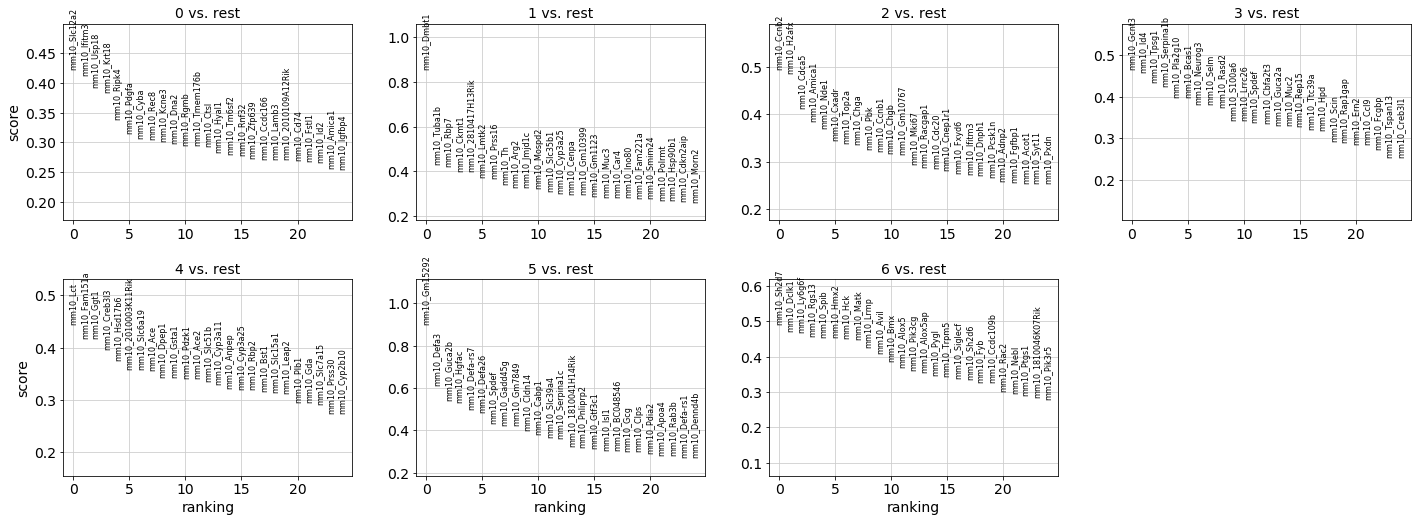

In [103]:
sc.tl.rank_genes_groups(adata, 'louvain', method='logreg')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

Many of the same genes were found in each of the three different tests but let's use the Mann-Whit results to create a list of marker genes.

In [104]:
sc.tl.rank_genes_groups(adata, 'louvain', method='wilcoxon')

ranking genes
    finished (0:00:00.55) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids


/opt/conda/lib/python3.6/site-packages/scanpy/tools/_rank_genes_groups.py:389: RuntimeWarning: invalid value encountered in log2
  rankings_gene_logfoldchanges.append(np.log2(foldchanges[global_indices]))


Let's pull out the top 5 ranked genes for each cluster and call the top two "marker genes".

In [105]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

,0,1,2,3,4,5,6
0,mm10_Zfos1,mm10_Dmbt1,mm10_Tubb5,mm10_Selm,mm10_Smim24,mm10_Defa26,mm10_Cd24a
1,mm10_Ifitm3,mm10_Mt1,mm10_Ube2c,mm10_Fcgbp,mm10_St3gal4,mm10_Defa3,mm10_Espn
2,mm10_Slc12a2,mm10_Mt2,mm10_Birc5,mm10_Tmsb10,mm10_2200002D01Rik,mm10_Gm15292,mm10_Aldh2
3,mm10_Amica1,mm10_Prap1,mm10_H2afx,mm10_Smim6,mm10_Ces2e,mm10_Clps,mm10_Trpm5
4,mm10_Ecscr,mm10_Gm1123,mm10_Tuba1b,mm10_Txndc5,mm10_Rbp2,mm10_Defa17,mm10_Mgst3


In [106]:
marker_genes = ['mm10_Zfos1','mm10_Ifitm3','mm10_Dmbt1','mm10_Mt1','mm10_Tubb5','mm10_Ube2c','mm10_Selm','mm10_Fcgbp',
               'mm10_Smim24','mm10_St3gal4','mm10_Defa26','mm10_Defa3','mm10_Cd24a','mm10_Espn']

Get a table with the scores and groups.

In [107]:
#adata.uns

In [108]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)

,0_n,0_p,1_n,1_p,2_n,2_p,3_n,3_p,4_n,4_p,5_n,5_p,6_n,6_p
0,mm10_Zfos1,7.441808e-67,mm10_Dmbt1,5.213700e-95,mm10_Tubb5,1.137366e-99,mm10_Selm,6.081284e-99,mm10_Smim24,5.964021e-102,mm10_Defa26,3.015522e-53,mm10_Cd24a,2.530380e-25
1,mm10_Ifitm3,7.634148e-64,mm10_Mt1,1.019377e-40,mm10_Ube2c,2.766640e-90,mm10_Fcgbp,2.108730e-98,mm10_St3gal4,2.419090e-100,mm10_Defa3,1.343363e-52,mm10_Espn,2.689100e-24
2,mm10_Slc12a2,1.292708e-51,mm10_Mt2,2.877535e-35,mm10_Birc5,5.345504e-88,mm10_Tmsb10,3.509623e-90,mm10_2200002D01Rik,8.113982e-98,mm10_Gm15292,1.647630e-47,mm10_Aldh2,3.225396e-23
3,mm10_Amica1,7.351190e-51,mm10_Prap1,1.354961e-32,mm10_H2afx,1.680781e-87,mm10_Smim6,1.802343e-80,mm10_Ces2e,5.115364e-91,mm10_Clps,1.085305e-45,mm10_Trpm5,4.448712e-23
4,mm10_Ecscr,1.800964e-42,mm10_Gm1123,1.078051e-31,mm10_Tuba1b,1.327916e-84,mm10_Txndc5,7.411119e-75,mm10_Rbp2,1.312604e-84,mm10_Defa17,8.108142e-42,mm10_Mgst3,4.271180e-22


Often times we want to compare a single cluster to another instead of one vs all

ranking genes


/opt/conda/lib/python3.6/site-packages/scanpy/tools/_rank_genes_groups.py:333: RuntimeWarning: invalid value encountered in log2
  rankings_gene_logfoldchanges.append(np.log2(foldchanges[global_indices]))


    finished (0:00:00.25) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids


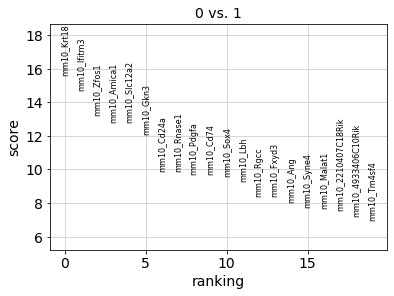

In [109]:
sc.tl.rank_genes_groups(adata, 'louvain', groups=['0'], reference='1', method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=['0'], n_genes=20)

Now if you want to save these genes to a .csv you can do

In [110]:
Clust0_v_clust1 = pd.DataFrame(adata.uns['rank_genes_groups']['names'])
Clust0_v_clust1.to_csv('clust0_v_clust1_top100.csv')

Now if we would like to visualize some of the marker genes across the groups
(if there are a lot of small violin plots, double click on them to enlarge)

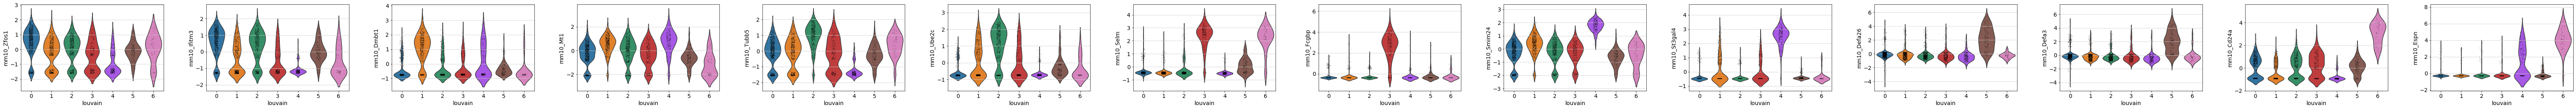

In [111]:
sc.pl.violin(adata, marker_genes, groupby='louvain')

Now let's pretend that using our marker genes we know what each cluster cell type is. We can mark the cell types by:

In [113]:
new_cluster_names = ['Distal E', 'Proximal E', 'Goblet', 'Tuft', 'Panepithelial', 'EEC','Stem']
adata.rename_categories('louvain', new_cluster_names)

Omitting rank_genes_groups/scores as old categories do not match.
Omitting rank_genes_groups/names as old categories do not match.
Omitting rank_genes_groups/logfoldchanges as old categories do not match.
Omitting rank_genes_groups/pvals as old categories do not match.
Omitting rank_genes_groups/pvals_adj as old categories do not match.


saving figure to file ./figures/tsnetsne_cellType_res0_25.pdf


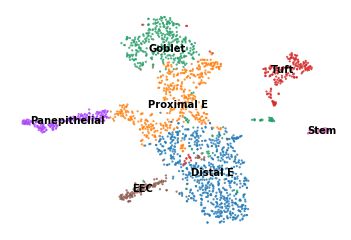

In [114]:
sc.pl.tsne(adata, color=['louvain'], legend_loc='on data' ,title='', frameon=False, legend_fontsize=10, alpha=0.8, size=20, save = 'tsne_cellType_res0_25.pdf')

Now that we annotated the cell types, let us visualize the marker genes.

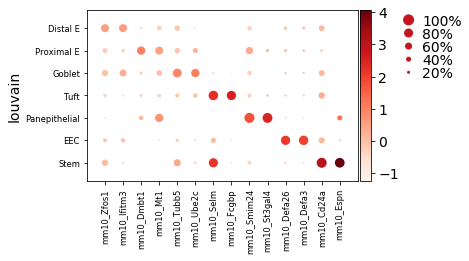

In [115]:
ax = sc.pl.dotplot(adata, marker_genes, groupby='louvain')

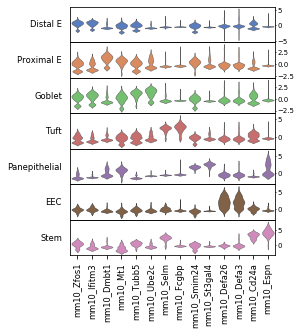

In [116]:
ax = sc.pl.stacked_violin(adata, marker_genes, groupby='louvain', rotation=90)

In [117]:
adata.write(results_file)

In [118]:
adata

AnnData object with n_obs × n_vars = 2030 × 1546 
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain'
    var: 'gene_ids', 'n_cells', 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca', 'neighbors', 'draw_graph', 'louvain', 'louvain_colors', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap', 'X_draw_graph_fr', 'X_tsne'
    varm: 'PCs'

## PAGA

By quantifying the connectivity of partitions (groups, clusters) of the single-cell graph, partition-based graph abstraction (PAGA) generates a much simpler abstracted graph (PAGA graph) of partitions, in which edge weights represent confidence in the presence of connections. By tresholding this confidence in scanpy.api.paga(), a much simpler representation of data can be obtained.

The confidence can be interpreted as the ratio of the actual versus the expected value of connetions under the null model of randomly connecting partitions. We do not provide a p-value as this null model does not precisely capture what one would consider “connected” in real data, hence it strongly overestimates the expected value. See an extensive discussion of this in https://scanpy.readthedocs.io/en/latest/references.html#wolf17i

In [119]:
adata = sc.read(results_file)

/opt/conda/lib/python3.6/site-packages/anndata/readwrite/read.py:440: DeprecationWarning: In a future version, read_h5ad will no longer explicitly support boolean arguments. Specify the read mode, or leave `backed=None`.
  DeprecationWarning,


Above we named our clusters based on the expression of some marker genes. If we would like to keep these names moving forward we do:

In [120]:
adata.obs['new_cluster_names'] = adata.obs['louvain']

In [121]:
sc.tl.paga(adata, groups='louvain')

running PAGA
    finished (0:00:00.17) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)


In the above parameters we could set the "use_rna_velocity" parameter to "True" and orient the edges in the graph to estimate the transitions. For RNA Velocity we need to have a loom file generated from preprocessed 10X data. 

In the plot parameters below, we are able to set a "root" node if we know where for example a differentiation started at. For this example we don't know a root so we did not set one.

In [122]:
paga_plot_params = dict(
    legend_fontsize=5,
    layout='fr',
    node_size_scale=0.5, threshold=0.01,
    node_size_power=0.9, alpha= 0.8,
    max_edge_width=0.5, size=20,
    fontsize=3.5)

--> added 'pos', the PAGA positions (adata.uns['paga'])
saving figure to file ./figures/paga_comparePBMC3000_PAGA_tSNE.pdf


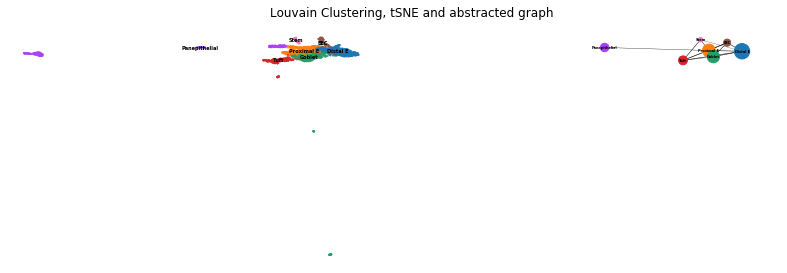

In [123]:
sc.pl.paga_compare(adata, title='Louvain Clustering, tSNE and abstracted graph', **paga_plot_params, save='PBMC3000_PAGA_tSNE')

We can see that our PAGA graph is not very well connected. To see where lower weight connections are we can change the threshold parameter which indicates what the floor for a connection should be.

--> added 'pos', the PAGA positions (adata.uns['paga'])


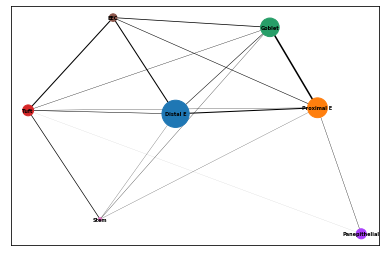

In [124]:
sc.pl.paga(adata, color='louvain', threshold=0.001, edge_width_scale= 1, node_size_scale=0.75, 
           node_size_power=1.5, fontsize=5)

## Pseudotime

Infer progression of cells through geodesic distance along the graph [Haghverdi16] [Wolf17i].

Reconstruct the progression of a biological process from snapshot data. Diffusion Pseudotime has been introduced by [Haghverdi16] and implemented within Scanpy [Wolf17]. Here, we use a further developed version, which is able to deal with disconnected graphs [Wolf17i] and can be run in a hierarchical mode by setting the parameter n_branchings>1. We recommend, however, to only use dpt() for computing pseudotime (n_branchings=0) and to detect branchings via paga(). For pseudotime, you need to annotate your data with a root cell. For instance:

adata.uns['iroot'] = np.flatnonzero(adata.obs['cell_types'] == 'Stem')[0]
This requires to run neighbors(), first. In order to reproduce the original implementation of DPT, use method=='gauss' in this. Using the default method=='umap' only leads to minor quantitative differences, though.

To set our root cell I have naturally picked stem cells as our root.

In [126]:
adata = sc.read(results_file)
root_cell = int(np.where(adata.obs['louvain'] == 'Stem')[0][0])
adata.uns['iroot'] = root_cell

In [127]:
sc.tl.dpt(adata)

computing Diffusion Maps using n_comps=15(=n_dcs)
    eigenvalues of transition matrix
    [1.         0.99853027 0.9947687  0.99412423 0.9921374  0.9899703
     0.98728555 0.9865195  0.97801197 0.9767182  0.9747102  0.9690296
     0.9668826  0.9623477  0.9578653 ]
    finished (0:00:00.15) --> added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns)
computing Diffusion Pseudotime using n_dcs=10
    finished (0:00:00.00) --> added
    'dpt_pseudotime', the pseudotime (adata.obs)


saving figure to file ./figures/draw_graph_frPseudo_Time_PBMC3000.png


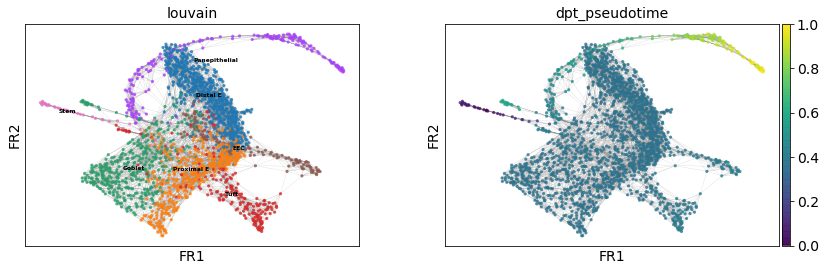

In [128]:
sc.pl.draw_graph(adata, color=['louvain', 'dpt_pseudotime'], layout= 'fr', legend_loc='on data', 
                 edges=True, legend_fontsize=6, alpha=0.8, size=40, save='Pseudo_Time_PBMC3000.png')